In [7]:
 import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from math import sqrt

# Configurar las opciones de visualización de pandas (opcional)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Rutas completas a los archivos
ruta_train = 'C:/Users/Marcio Pineda/Documents/Archivos Python/datasets/traincase.csv'
ruta_test = 'C:/Users/Marcio Pineda/Documents/Archivos Python/datasets/testcase.csv'

# Cargar los conjuntos de datos
df_train = pd.read_csv(ruta_train)
df_test = pd.read_csv(ruta_test)


# Función para convertir cadenas de precios a flotantes
def convert_currency_to_float(df, column_name):
    if column_name in df.columns:
        # Eliminar el símbolo del dólar y convertir a flotante
        df[column_name] = df[column_name].str.replace('$', '').str.strip().astype(float)

# Lista de columnas que pueden contener valores monetarios como cadenas
currency_columns = ['Search Engine Bid', 'Avg. Cost per Click']

# Aplicar la conversión en ambos DataFrames
for col in currency_columns:
    convert_currency_to_float(df_train, col)
    convert_currency_to_float(df_test, col)

# Ajustar el código para asegurarse de que solo se apliquen operaciones de cadena a columnas de tipo string
cols_to_convert = ['Impressions', 'Avg. Pos.', 'Avg. Cost per Click', 'Clicks']

for col in cols_to_convert:
    if col in df_train.columns and df_train[col].dtype == 'object':
        df_train[col] = df_train[col].str.replace(',', '').astype(float)
    if col in df_test.columns and df_test[col].dtype == 'object':
        df_test[col] = df_test[col].str.replace(',', '').astype(float)

# Continúa con la concatenación de los conjuntos de datos y el resto del proceso
df_train['set'] = 'Not Kaggle'
df_test['set'] = 'Kaggle'
df_full = pd.concat([df_train, df_test], ignore_index=True)

categorical_vars = ['Publisher Name', 'Keyword', 'Match Type', 'Campaign', 'Keyword Group', 'Category', 'Bid Strategy', 'Status', 'Search Engine Bid'] 

In [28]:
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_encoded = encoder.fit_transform(df_train[categorical_vars]).toarray()
feature_names = encoder.get_feature_names_out(categorical_vars)
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=feature_names)
df_train_processed = pd.concat([df_train.drop(columns=categorical_vars), X_train_encoded_df], axis=1)

# Asegurando que 'y_train' esté definido
y_train = df_train_processed['Clicks']

# Asegurando que 'X_train' esté definido excluyendo la columna objetivo y otras no necesarias
X_train = df_train_processed.drop(columns=['Clicks', 'set', 'entry_id'], errors='ignore')

# Transformación logarítmica
X_train['Log_Impressions'] = np.log1p(X_train['Impressions'])


In [29]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from math import sqrt
from sklearn.metrics import mean_squared_error

param_distributions = {
    'max_depth': [3, 5, 7, 9, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
}

random_search = RandomizedSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_distributions=param_distributions,
    n_iter=100,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=1,
    random_state=42,
    verbose=1
)

# Asegúrate de que 'X_train' y 'y_train' están definidos antes de ajustar
random_search.fit(X_train, y_train)

# Extracción de los mejores parámetros y cálculo del RMSE
best_params = random_search.best_params_
best_rmse = sqrt(-random_search.best_score_)

print(f"Mejores parámetros: {best_params}")
print(f"Mejor RMSE: {best_rmse}")



Fitting 5 folds for each of 100 candidates, totalling 500 fits
Mejores parámetros: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 7}
Mejor RMSE: 801.328237594649


In [32]:
from sklearn.model_selection import GridSearchCV


# Realiza un ajuste fino de los hiperparámetros alrededor de los mejores encontrados previamente
param_grid = {
    'min_samples_split': [4, 5, 6],
    'min_samples_leaf': [3, 4, 5],
    'max_features': [None, 'sqrt'],
    'max_depth': [None, 10, 20]
}

# Inicializa el GridSearchCV con el árbol de decisión como estimador
grid_search = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           verbose=1)

grid_search.fit(X_train, y_train)

# Muestra los mejores parámetros y el RMSE correspondiente
best_params_grid = grid_search.best_params_
best_rmse_grid = sqrt(-grid_search.best_score_)

print(f"Mejores parámetros (GridSearchCV): {best_params_grid}")
print(f"Mejor RMSE (GridSearchCV): {best_rmse_grid}")



Fitting 5 folds for each of 54 candidates, totalling 270 fits
Mejores parámetros (GridSearchCV): {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 4}
Mejor RMSE (GridSearchCV): 804.5387448824845


RMSE promedio de CV: 707.6405817297959


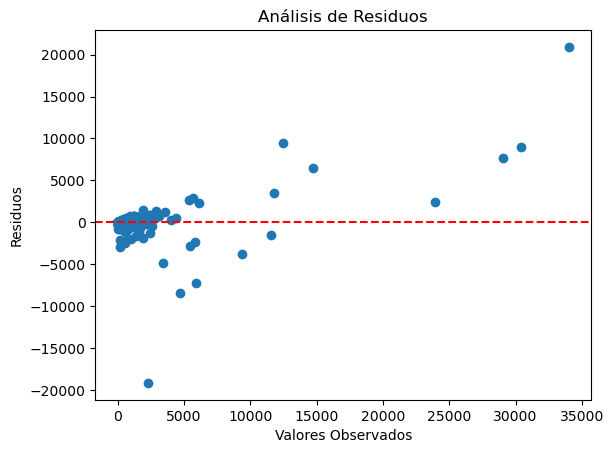

In [16]:
from sklearn.model_selection import cross_val_score

# Continuando desde donde dejamos el código anterior...

# Extracción de los mejores parámetros y cálculo del RMSE
best_model = random_search.best_estimator_

# Validación Cruzada Robusta
scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mean_rmse_cv = np.mean(np.sqrt(-scores))

print(f"RMSE promedio de CV: {mean_rmse_cv}")

# Análisis de Residuos
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_train)
residuos = y_train - y_pred

# Podrías usar matplotlib para graficar los residuos y detectar patrones
import matplotlib.pyplot as plt

plt.scatter(y_train, residuos)
plt.xlabel('Valores Observados')
plt.ylabel('Residuos')
plt.title('Análisis de Residuos')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Ingeniería de características (ejemplo conceptual)
# Agregar nuevas características que creas relevantes basado en el conocimiento del dominio
# Por ejemplo, una transformación logarítmica de una característica numérica que tiene una distribución sesgada
# X_train['log_feature'] = np.log1p(X_train['some_feature'])

# Selección de características basada en la importancia
importances = best_model.feature_importances_
# Este paso requiere una revisión manual para decidir un umbral de importancia

# Filtrar características basadas en la importancia (ejemplo conceptual)
# features_selected = [col for col, imp in zip(X_train.columns, importances) if imp > threshold]
# X_train_selected = X_train[features_selected]


Training RMSE: 554.9923064511804


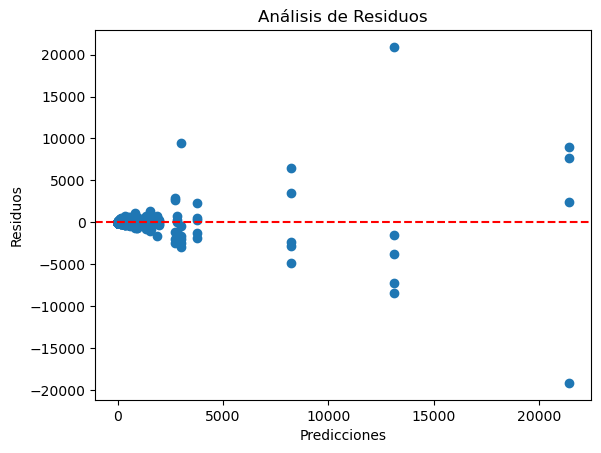

In [17]:
# Análisis de errores
from sklearn.metrics import mean_squared_error

# Entrenar el modelo con los mejores hiperparámetros encontrados
best_tree_model = DecisionTreeRegressor(
    max_depth=10,
    max_features=None,
    min_samples_leaf=4,
    min_samples_split=4,
    random_state=42
)
best_tree_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de entrenamiento
train_predictions = best_tree_model.predict(X_train)

# Calcular el RMSE en el conjunto de entrenamiento
train_rmse = sqrt(mean_squared_error(y_train, train_predictions))
print(f"Training RMSE: {train_rmse}")

# Analizar los residuos para identificar patrones
residuals = y_train - train_predictions

# Graficar los residuos para identificar patrones (añadir este código a tu script de visualización)
import matplotlib.pyplot as plt

plt.scatter(train_predictions, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Análisis de Residuos')
plt.show()

In [41]:
best_tree_model = DecisionTreeRegressor(
    max_depth=10,
    max_features=None,
    min_samples_leaf=4,
    min_samples_split=4,
    random_state=42
)
best_tree_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de entrenamiento
train_predictions = best_tree_model.predict(X_train)

# Calcular el RMSE en el conjunto de entrenamiento
train_rmse = sqrt(mean_squared_error(y_train, train_predictions))

# Verificar si el RMSE calculado coincide con el dado
expected_rmse = 554.9923064511804
if abs(train_rmse - expected_rmse) < 0.0001:  # Un pequeño margen de error debido a la precisión de punto flotante
    print(f"El RMSE calculado {train_rmse} es igual al esperado {expected_rmse}.")
else:
    print(f"El RMSE calculado {train_rmse} es diferente al esperado {expected_rmse}.")

El RMSE calculado 554.9923064511804 es igual al esperado 554.9923064511804.


In [40]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_tree_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Calcula RMSE para cada fold
cv_rmse_scores = [sqrt(-score) for score in cv_scores]

# Calcula el promedio y la desviación estándar de los RMSE de la validación cruzada
mean_cv_rmse = np.mean(cv_rmse_scores)
std_cv_rmse = np.std(cv_rmse_scores)

print(f"RMSE promedio de la validación cruzada: {mean_cv_rmse:.2f}")
print(f"Desviación estándar del RMSE de la validación cruzada: {std_cv_rmse:.2f}")

RMSE promedio de la validación cruzada: 710.78
Desviación estándar del RMSE de la validación cruzada: 376.94


In [24]:
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Configurar el modelo con hiperparámetros menos complejos
simplified_tree_model = DecisionTreeRegressor(
    max_depth=8,  # Reducir la profundidad máxima del árbol
    min_samples_leaf=6,  # Aumentar el número mínimo de muestras requeridas en una hoja
    min_samples_split=8,  # Aumentar el número mínimo de muestras requeridas para dividir un nodo interno
    random_state=42
)

# Entrenar el modelo con el conjunto de entrenamiento dividido
simplified_tree_model.fit(X_train_split, y_train_split)

# Evaluar el modelo en el conjunto de validación
val_predictions = simplified_tree_model.predict(X_val)
val_rmse = sqrt(mean_squared_error(y_val, val_predictions))

print(f"Validation RMSE with simplified model: {val_rmse}")

Validation RMSE with simplified model: 645.9368411042725


In [31]:
# Entrenamiento del modelo
best_tree_model = DecisionTreeRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=4, random_state=42)
best_tree_model.fit(X_train, y_train)
train_predictions = best_tree_model.predict(X_train)

# Cálculo de residuos y eliminación de outliers
residuos = y_train - train_predictions
residual_threshold = residuos.std() * 3
outliers = residuos.abs() > residual_threshold
X_train_no_outliers = X_train[~outliers]
y_train_no_outliers = y_train[~outliers]

# Reentrenamiento del modelo sin outliers
best_tree_model.fit(X_train_no_outliers, y_train_no_outliers)
train_predictions_no_outliers = best_tree_model.predict(X_train_no_outliers)
train_rmse_no_outliers = sqrt(mean_squared_error(y_train_no_outliers, train_predictions_no_outliers))
print(f"Training RMSE after outlier removal: {train_rmse_no_outliers}")


Training RMSE after outlier removal: 154.5011198774245


In [33]:
from sklearn.model_selection import cross_val_score

# Realizar la validación cruzada en el conjunto de datos sin los valores atípicos
cv_scores_no_outliers = cross_val_score(
    best_tree_model, X_train_no_outliers, y_train_no_outliers, cv=5, scoring='neg_mean_squared_error')

# Calcular el RMSE para cada fold de la validación cruzada
cv_rmse_scores_no_outliers = [sqrt(-score) for score in cv_scores_no_outliers]

# Calcular el promedio y la desviación estándar de los RMSE de la validación cruzada
mean_cv_rmse_no_outliers = np.mean(cv_rmse_scores_no_outliers)
std_cv_rmse_no_outliers = np.std(cv_rmse_scores_no_outliers)

print(f"CV RMSE scores without outliers: {cv_rmse_scores_no_outliers}")
print(f"Average CV RMSE without outliers: {mean_cv_rmse_no_outliers}")
print(f"Standard Deviation CV RMSE without outliers: {std_cv_rmse_no_outliers}")


CV RMSE scores without outliers: [121.37522191637142, 168.37813078975367, 168.2631319263022, 336.33297708474987, 187.2445743947568]
Average CV RMSE without outliers: 196.3188072223868
Standard Deviation CV RMSE without outliers: 73.30846166440698


In [76]:
from sklearn.model_selection import KFold

# Configuramos la validación cruzada manual con 5 pliegues
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Creamos listas para almacenar los resultados
fold_rmse = []
fold_data = []

# Iteramos a través de los pliegues
for train_index, val_index in kf.split(X_train):
    # Dividimos los datos en conjuntos de entrenamiento y validación para este pliegue
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Entrenamos el modelo
    best_tree_model.fit(X_train_fold, y_train_fold)

    # Hacemos predicciones en el conjunto de validación
    val_predictions_fold = best_tree_model.predict(X_val_fold)

    # Calculamos el RMSE para este pliegue
    val_rmse_fold = sqrt(mean_squared_error(y_val_fold, val_predictions_fold))
    
    # Almacenamos el RMSE en nuestra lista de resultados
    fold_rmse.append(val_rmse_fold)
    
    # Almacenamos los índices de este pliegue para inspección futura
    fold_data.append((train_index, val_index))

# Revisamos los resultados
for i, rmse in enumerate(fold_rmse, 1):
    print(f"Fold {i}, RMSE: {rmse}")

# Identificamos y revisamos los datos del cuarto pliegue
train_index_4th_fold, val_index_4th_fold = fold_data[3]
X_train_4th_fold = X_train.iloc[train_index_4th_fold]
y_train_4th_fold = y_train.iloc[train_index_4th_fold]
X_val_4th_fold = X_train.iloc[val_index_4th_fold]
y_val_4th_fold = y_train.iloc[val_index_4th_fold]

# Ahora puedes inspeccionar X_train_4th_fold, y_train_4th_fold, X_val_4th_fold, y_val_4th_fold
# para buscar cualquier particularidad o diferencias en los datos que podrían explicar el alto RMSE.

# Por ejemplo, para inspeccionar las estadísticas básicas de las variables en el cuarto pliegue de validación
print(X_val_4th_fold.describe())
print(y_val_4th_fold.describe())


Fold 1, RMSE: 926.1004855637236
Fold 2, RMSE: 1171.6941377249325
Fold 3, RMSE: 840.6423543192599
Fold 4, RMSE: 1073.616796212117
Fold 5, RMSE: 511.9653853815644
        Impressions   Avg. Pos.  Avg. Cost per Click  Publisher Name_Google - Global  Publisher Name_Google - US  Publisher Name_MSN - Global  Publisher Name_MSN - US  Publisher Name_Overture - Global  Publisher Name_Overture - US  Publisher Name_Yahoo - US  Keyword_.com air france  Keyword_[air france]  Keyword_[airfrance]  Keyword_[flight to istanbul]  Keyword_[flight to london]  Keyword_[flights to istanbul]  Keyword_[flights to london]  Keyword_[fly to istanbul]  Keyword_[istanbul airfare]  Keyword_[istanbul airlines]  Keyword_[istanbul airport]  Keyword_[istanbul cheap flights]  Keyword_[istanbul flight]  Keyword_[istanbul flights]  Keyword_[istanbul tickets]  Keyword_[london cheap flights]  Keyword_[london flights]  Keyword_[london travel]  Keyword_[rome cheap flights]  Keyword_[venice cheap flight]  Keyword_[venice cheap

In [43]:
# Generar predicciones para el conjunto de prueba
test_predictions = best_tree_model.predict(X_test)

# Preparar el DataFrame para la sumisión a Kaggle
kaggle_submission = pd.DataFrame({
    'ID': df_test['entry_id'],  # Asegúrate de usar la columna correcta como ID
    'Clicks': test_predictions
})

# Guardar el archivo de sumisión con un nuevo nombre para diferenciarlo del anterior
submission_filename = 'decision_tree_kaggle_submission_updated.csv'
kaggle_submission.to_csv(submission_filename, index=False)

print(f"Archivo de sumisión guardado como: {submission_filename}")





Archivo de sumisión guardado como: decision_tree_kaggle_submission_updated.csv
